In [4]:
# from  lunarLanding import DQNAgent

%matplotlib inline

from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Dropout, Activation, Input, concatenate, add
from keras.utils import np_utils
from keras.optimizers import Adam
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

import pylab as pl
from IPython import display


import itertools
import gym

import numpy as np
from scipy.special import softmax
import random
from sklearn import preprocessing
import matplotlib.pyplot as plt
import time

import os

['/job:localhost/replica:0/task:0/device:GPU:0']


In [9]:
import random
import gym
import numpy as np
from collections import deque
from scipy.special import softmax
import random
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.models import Sequential
import time

import os

# Deep Q-learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size, memsize = 7000, ga = 0.95, explore_rate = 1, explore_decay = 0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen = memsize)
        self.gamma = ga    # discount rate
        self.epsilon = explore_rate  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = explore_decay
        self.target_model = Sequential()
        self.engine_model = Sequential()

    def remember(self, state, action, reward, next_state, done):
        if not done:
            self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
                
        if np.random.rand() <= self.epsilon:
            chose = np.random.randint(0,4)
            return chose
        
        ACTION_SIZE = 4
        STATE_SIZE = 8
        bestStep = 0
        initialStep = np_utils.to_categorical(0, ACTION_SIZE).reshape(1, ACTION_SIZE)
        best_reward = self.target_model.predict([state.reshape(1, STATE_SIZE), initialStep])[0]#我有加[0]
        for action in range(1, ACTION_SIZE):
            step = np_utils.to_categorical(action, ACTION_SIZE).reshape(1, ACTION_SIZE)
            predict = self.target_model.predict([state.reshape(1, STATE_SIZE), step])[0]#
            if(predict > best_reward):
                bestStep = action
                best_reward = predict
                
        return bestStep
#     def replay(self, batch_size):
#         minibatch = random.sample(self.memory, batch_size)
#         xs = []
#         ys = []

#         for state, action, reward, next_state, done in minibatch:
#             target = reward

#             if not done:
#                 target = reward + np.multiply (self.gamma , self.model.predict(next_state)[0] )
#             else:
#                 target = np.multiply (self.gamma , self.model.predict(next_state)[0] )
                
#             xs.append(state[0])
#             ys.append(target)
#         xs = np.array(xs)
#         ys = np.array(ys)
#         self.model.fit(xs, ys, epochs= 1, verbose=0 , batch_size=batch_size)
                
#         if self.epsilon > self.epsilon_min:
#             self.epsilon *= self.epsilon_decay
    
    def save_model(self, model_name = './checkpoint.h5', mem_name = 'memory'):
        self.target_model.save(model_name)

    def load_model(self,  model_name = './checkpoint-10.h5' , mem_name = 'memory-10.npy'):
        self.target_model.load_weights(model_name)
        self.engine_model.load_weights(model_name)
        self.memory = np.load(mem_name, allow_pickle=True)
        self.memory = deque(self.memory)
    def learn (self):
        ACTION_SIZE = 4
        STATE_SIZE = 8
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon_decay* 10
        output = list(itertools.islice(agent.memory, 0, None))
        xs_state = []
        xs_action = []
        ys = []
        for i in output:
            target = i[2]
            if not i[4]:
                Next_state = i[3].reshape(1, STATE_SIZE)
                
                bestStep = 0
                initialStep = np_utils.to_categorical(0, ACTION_SIZE).reshape(1, ACTION_SIZE)
                best_reward = self.target_model.predict([Next_state.reshape(1, STATE_SIZE), initialStep])[0]#我有加[0]
                for action in range(1, ACTION_SIZE):
                    step = np_utils.to_categorical(action, ACTION_SIZE).reshape(1, ACTION_SIZE)
                    predict = self.target_model.predict([Next_state.reshape(1, STATE_SIZE), step])[0]#
                    if(predict > best_reward):
                        bestStep = action
                        best_reward = predict
                
                Step = np_utils.to_categorical(bestStep, ACTION_SIZE).reshape(1, ACTION_SIZE)
                
                target += self.gamma * self.target_model.predict([i[3].reshape(1, STATE_SIZE), Step])[0]
            ys.append(target)
            
#             print('reward',i[2])
            step = np_utils.to_categorical(i[1], 4).reshape(1, 4)

            xs_state.append(i[0][0])
            xs_action.append(step)

        ys = np.array(ys)
        lgn = len(xs_state)
        xs_action = np.array(xs_action).reshape(lgn, 4)
            
#         print(xs.shape)
        self.engine_model.fit([xs_state, xs_action], ys, epochs = 4 , verbose = 1)
        del self.memory
        
        self.memory = deque(maxlen = 9000)
#         print(len(self.memory))
        self.engine_model.save_weights("checkpoint-10.h5")
        self.target_model.set_weights(self.engine_model.get_weights())

In [10]:
input_state = Input(shape=(8,))
input_action = Input(shape=(4,))

m = Dense(64)(input_state)
m = BatchNormalization()(m)

m = Dense(64, activation='relu')(m)
m = BatchNormalization()(m)

m = Dense(64, activation='relu')(m)
m = BatchNormalization()(m)

# m = Model(inputs = input_state, outputs = m)

#####

m_i = Dense(32,activation='relu')(input_action)
m_i = BatchNormalization()(m_i)

m_i = Dense(32,activation='relu')(m_i)
m_i = BatchNormalization()(m_i)

m_i = Dense(32,activation='relu')(m_i)
m_i = BatchNormalization()(m_i)

# m_i = Model(inputs = input_action, outputs = m_i)

u = concatenate([m,m_i])

u = Dense(64, activation='relu')(u)
u = BatchNormalization()(u)

u = Dense(32, activation='relu')(u)
u = BatchNormalization()(u)

u = Dense(1)(u)

u = Model(inputs= [input_state,input_action ], outputs = u)

u.compile(loss='mse', optimizer=Adam())
u.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 8)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 64)           576         input_3[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 32)           160         input_4[0][0]                    
__________________________________________________________________________________________________
batch_norm

In [11]:
env = gym.make('LunarLander-v2')
state_size = 8
action_size = 4
agent = DQNAgent(state_size, action_size, memsize= 20000)

agent.target_model = u
agent.engine_model = u

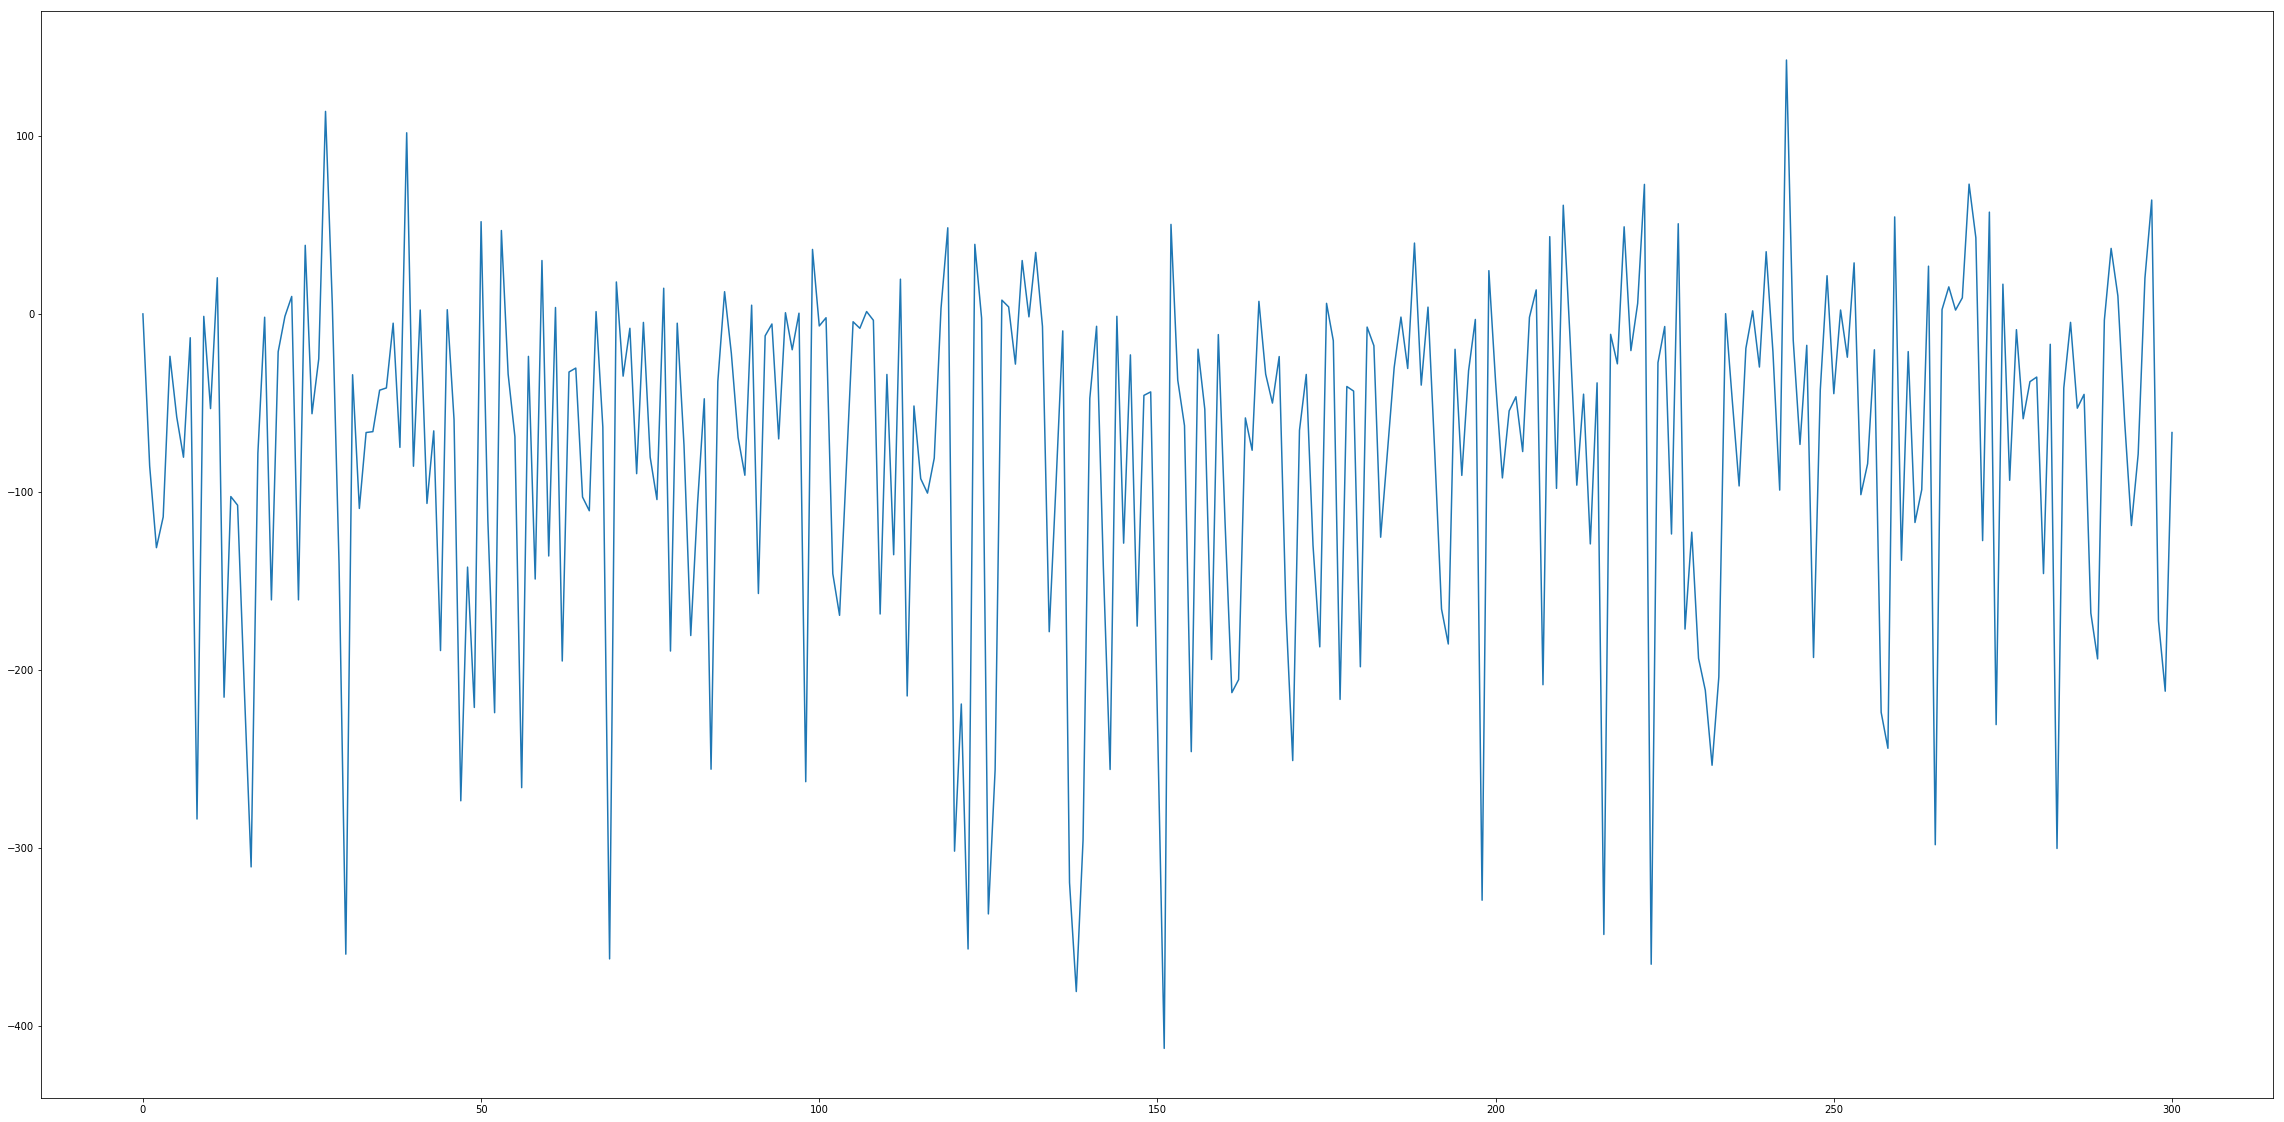

300 0.018480539321899414
301 0.011597156524658203
302 0.019560575485229492
303 0.028977155685424805
304 0.015186786651611328
305 0.012775182723999023
306 0.01658916473388672
307 0.013358831405639648
308 0.02458024024963379
309 0.013851404190063477
310 0.014354467391967773
311 0.015514135360717773
312 0.018932104110717773
313 0.014610528945922852
314 0.018434524536132812
315 0.02168869972229004
316 0.011608600616455078
317 0.02595376968383789
318 0.011913776397705078
319 0.0076944828033447266
320 0.01007986068725586
321 0.010734796524047852
322 0.018324613571166992
323 0.018355369567871094
324 0.01562047004699707
325 0.011611700057983398
326 0.016541242599487305
327 0.02298259735107422
328 0.01694178581237793
329 0.018133163452148438
330 0.01629185676574707
331 0.012487649917602539
332 0.014202356338500977
333 0.009256839752197266
334 0.02042698860168457
335 0.009570121765136719
336 0.021999597549438477
337 0.018403291702270508
338 0.012610673904418945
339 0.012862205505371094
340 0.013

KeyboardInterrupt: 

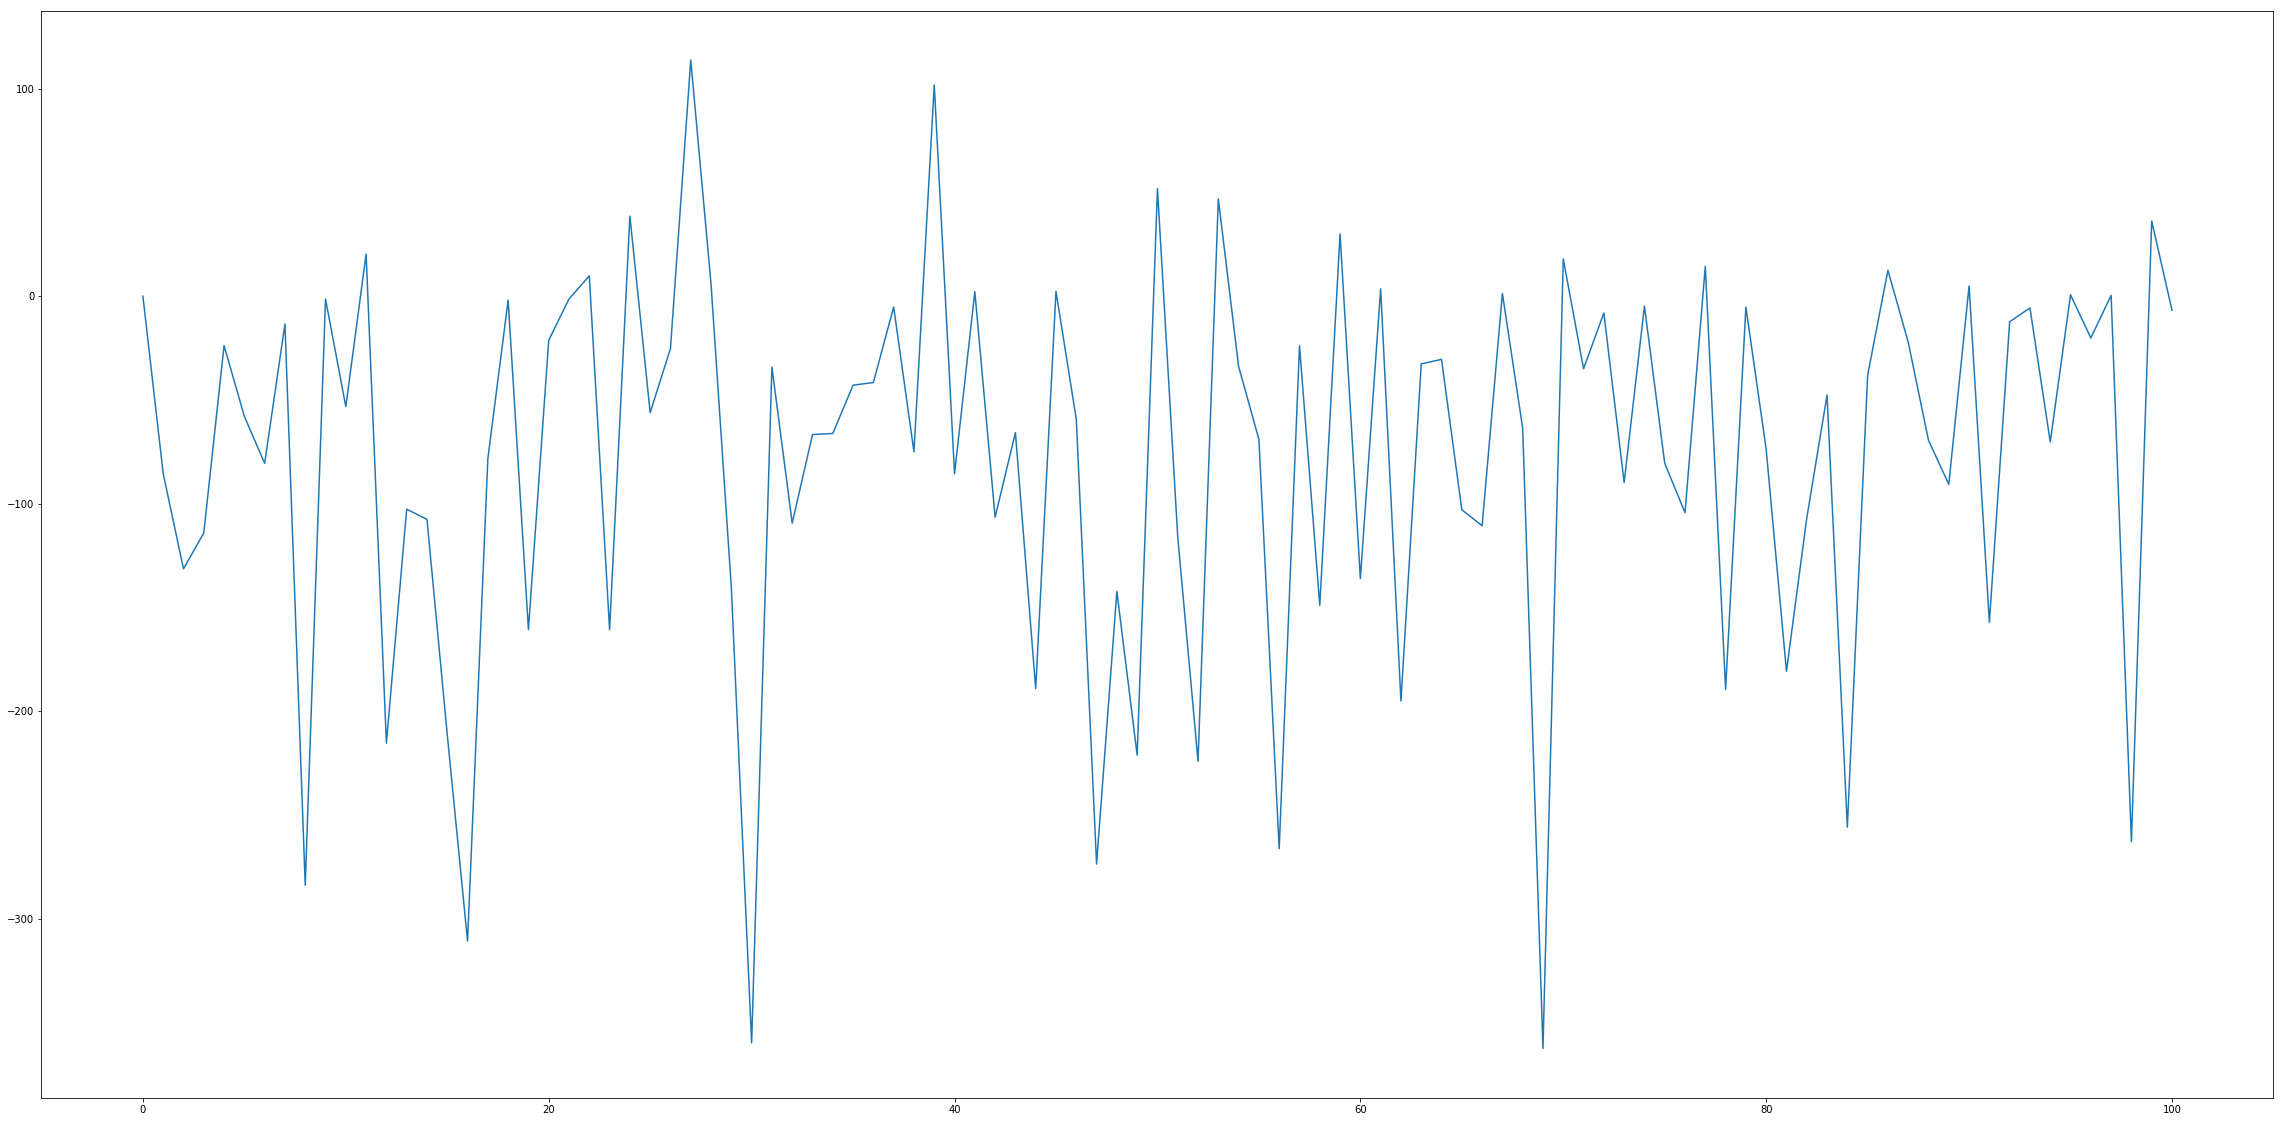

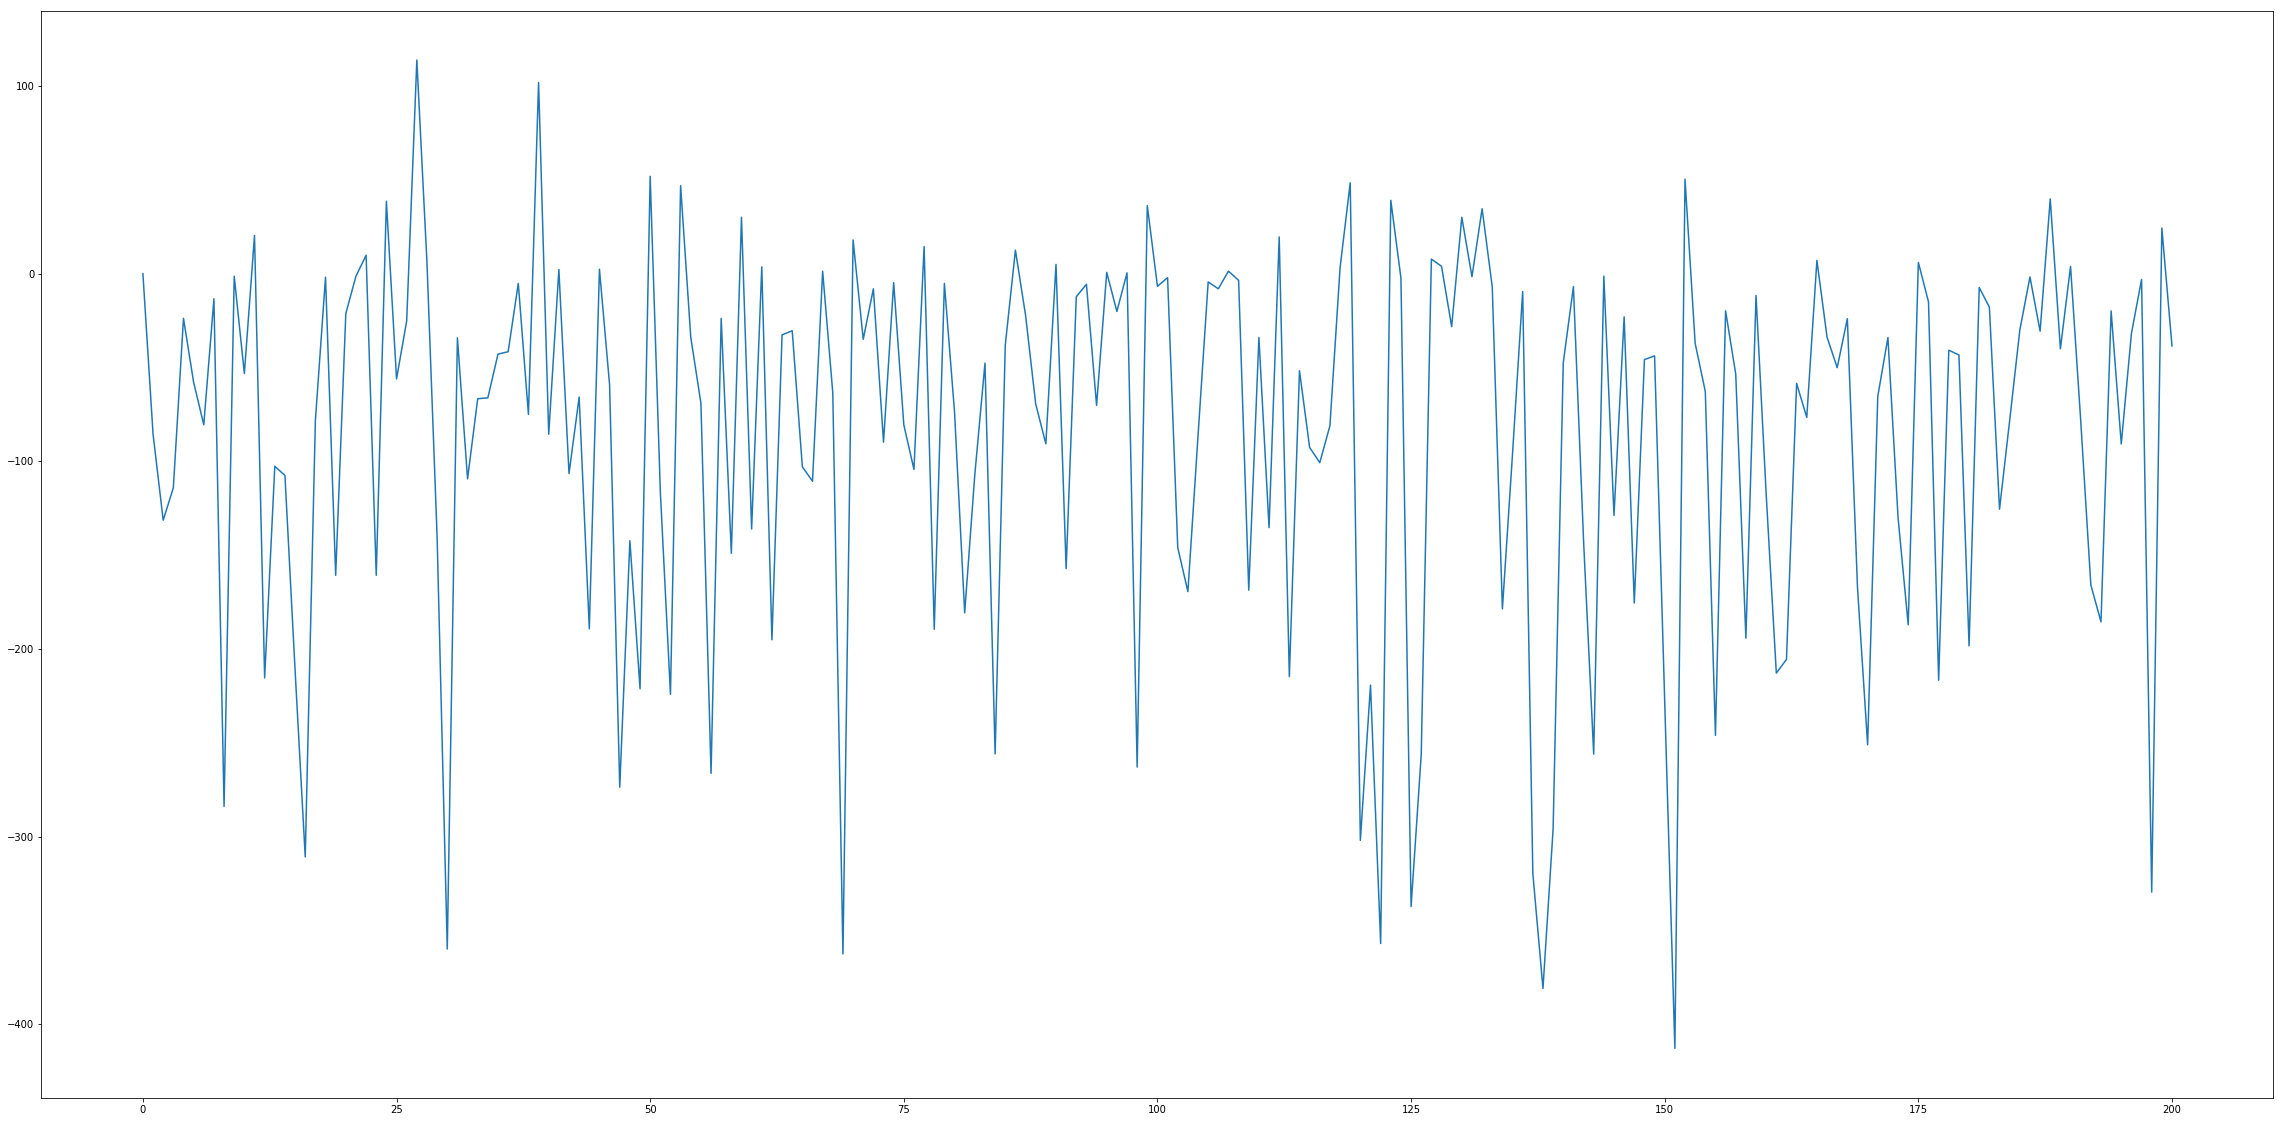

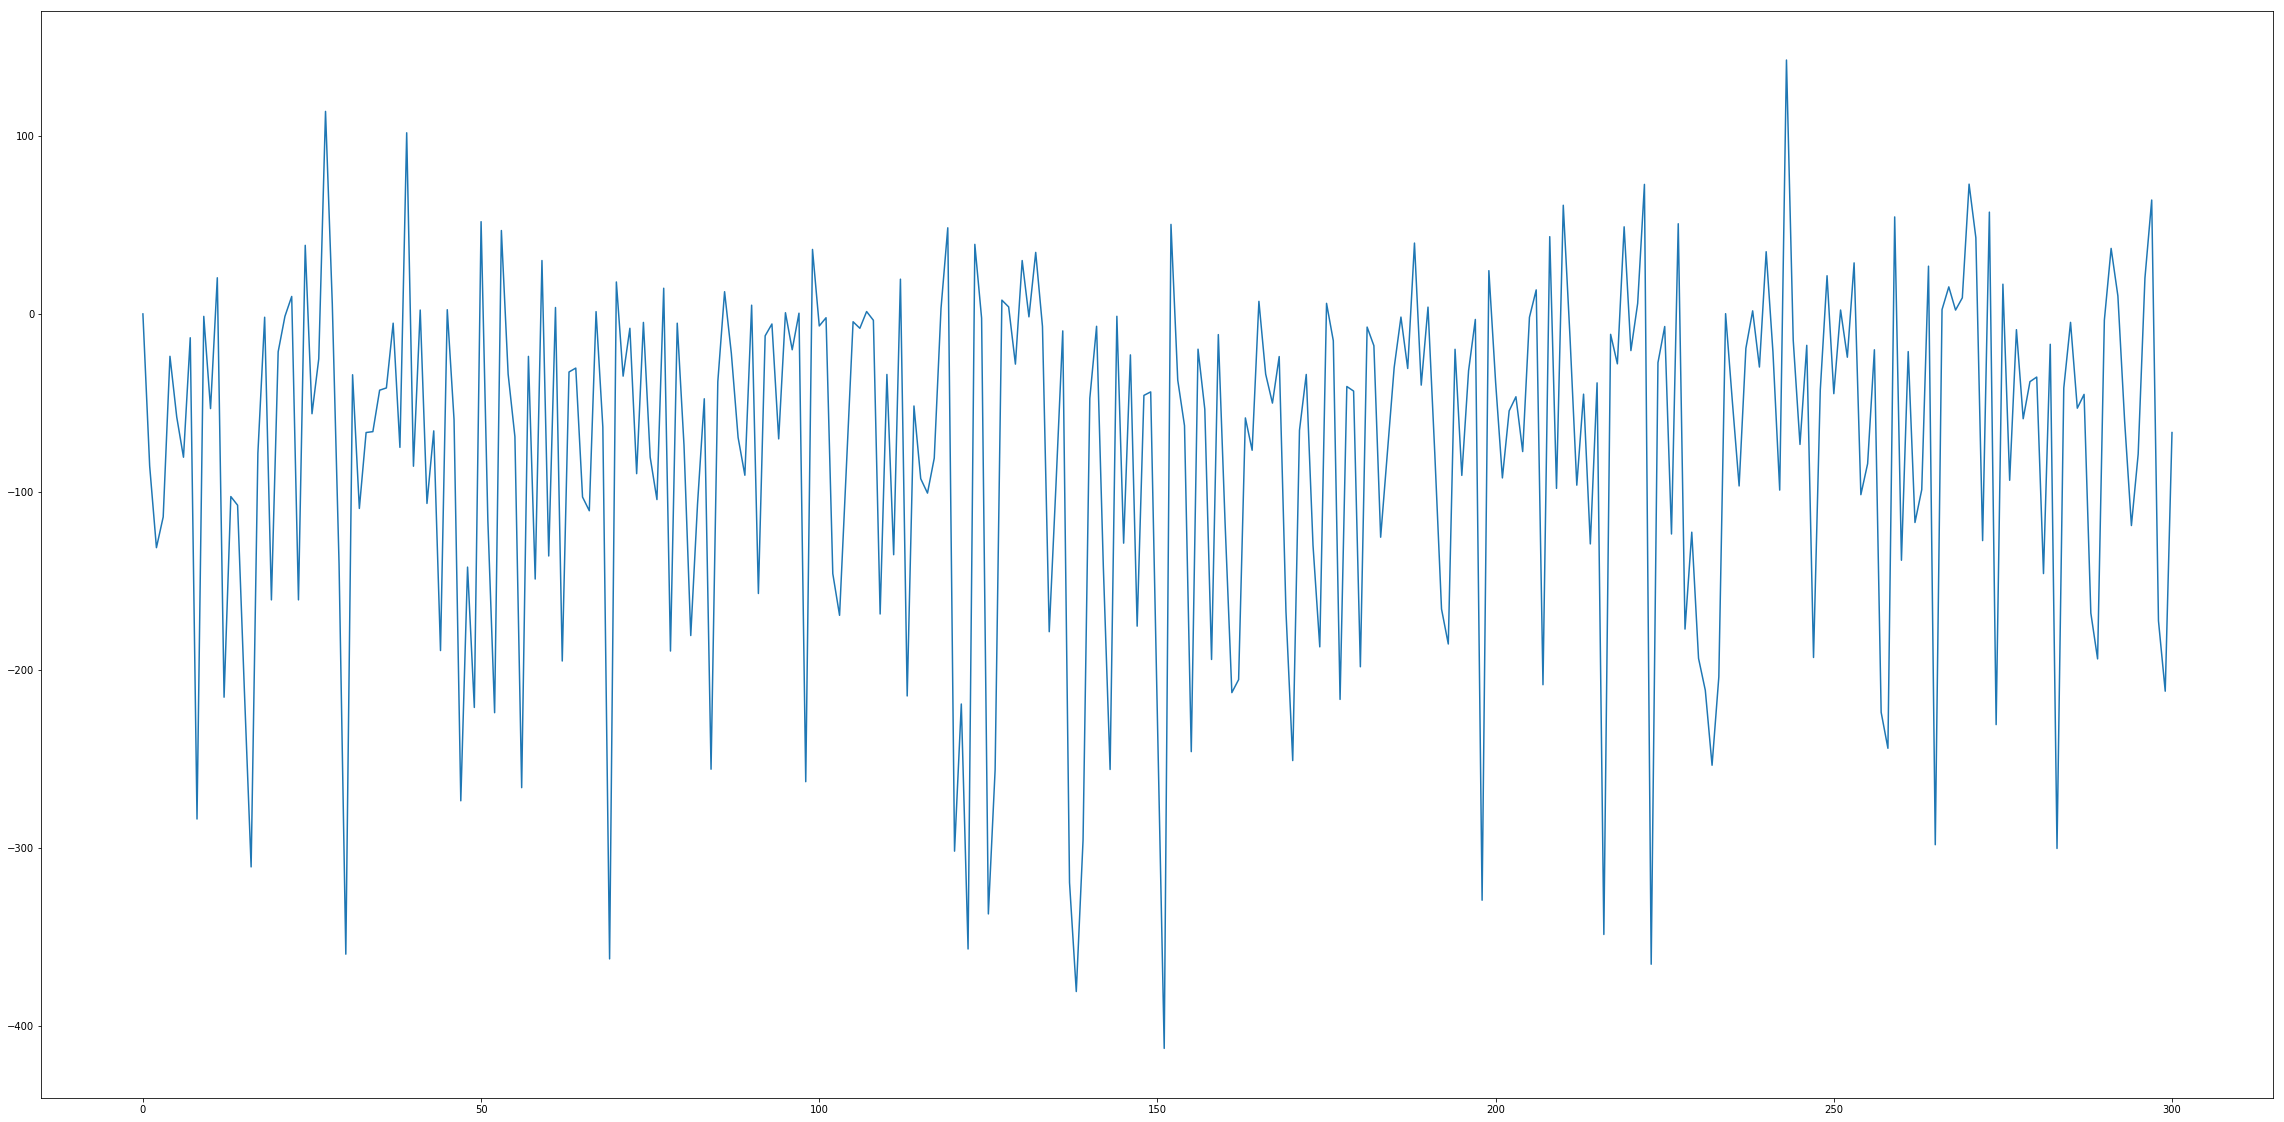

In [12]:
done = False
batch_size = 30
game_history = [0]


explore = True
t_steps = 0
for episode in range(3000):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    start = time.time()
    for timee in range(450):

        action = agent.act(state)
        
        next_state, reward, done, _ = env.step(action)
        

        next_state = np.reshape(next_state, [1, state_size])

        agent.remember(state, action, reward, next_state, done)
        state = next_state
        
        if done:
            break
        
        total_reward += reward

    game_history.append(total_reward)
    print(episode, time.time() - start)
    if episode % 100 == 99:
        print("epi:{} score: {} mean:{} spent:{}".format(episode, total_reward, np.mean(game_history[-99:]), time.time() - start))
        agent.learn()
        agent.save_model()
        np.save("game_history-10", game_history)
        pl.figure(figsize=(40,20))
        pl.plot(game_history)
        display.clear_output(wait=True)
        display.display(pl.gcf())
